In [1]:
import pandas as pd
import csv
import os
import json
import urllib.parse
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from biomed_apis import *
from biomedkg_utils import *

## Transcription Factors

##### TF Gene Name -targets-> Target Gene Name

In [3]:
tf_gene_name_2_target_gene_name = dict() # TF gene name to target gene name
gene_names = set() # Gene Names (Tfs and targets)
tf_gene_names = set() # Transcription Factor gene names
target_gene_names = set() # Target gene names

root = 'input/GRNdb/'

for file in os.listdir(root):
    if 'GTEx-regulons' in file:
        
        for line in open(root+file):
            line = line.strip().split('\t')
        
            confidence = line[5]
            if confidence == 'High':

                # Gene names
                tf_gene_name = line[0]      
                targ_gene_name = line[1]  

                # Save gene names
                gene_names.add(tf_gene_name)
                gene_names.add(targ_gene_name)     
                tf_gene_names.add(tf_gene_name)     
                target_gene_names.add(targ_gene_name)

                # TF Gene -targets-> Target Gene
                tf_gene_name_2_target_gene_name.setdefault(tf_gene_name,set()).add(targ_gene_name)

# Change the values from set into a list
tf_gene_name_2_target_gene_name = switch_dictset_to_dictlist(tf_gene_name_2_target_gene_name)

##### Gene Name -is- Protein ID

In [3]:
# You can use this link if the API isn't working: 
# https://www.uniprot.org/id-mapping
with open('output/protein2gene/gene_names.txt','w') as fout:
    for gene_name_count, gene_name in enumerate(gene_names):
        fout.write(gene_name+',')

In [7]:
'''API'''
#job_id = submit_id_mapping_UniProtAPI(
#                from_db = 'Gene_Name',
#                to_db = 'UniProtKB-Swiss-Prot', 
#                ids = gene_names)

job_id = 'f0752f32064b441b1b7959cae87a8eaeea058c07' # Pasted from the web tool

# This checks on the job until it is finished
if check_id_mapping_results_ready_UniProtAPI(job_id):
    link = get_id_mapping_results_link_UniProtAPI(job_id)
    results = get_id_mapping_results_search_UniProtAPI(link)

In [8]:
'''Dictionary from API data'''
gene_name_2_protein_id = get_to_uniprotid_from_genename_mapping_dict_UniProtAPI(
                                                    results, 
                                                    [9606], 
                                                    filter_by_reviewed = True)

removed_genes = 0
for gene_name, protein_ids in gene_name_2_protein_id.copy().items():
    if len(protein_ids) > 1:
        gene_name_2_protein_id.pop(gene_name)
        removed_genes += 1
print(removed_genes, 'genes removed because they were ambiguous\n'+\
                     'Names mapped to multiple proteins (possibly ok, but possibly not)')

38 genes removed because they were ambiguous
Names mapped to multiple proteins (possibly ok, but possibly not)


##### Protein ID -encoded by-> Gene ID

In [9]:
'''Dictionary (all known mappings)'''
protein_ids_2_gene_ids = json.load(open('output/protein2gene/all_uniprot2entrez.json','r'))
gene_ids_2_protein_ids = json.load(open('output/protein2gene/all_entrez2uniprot.json','r'))

##### Gene Name -is- Gene ID

In [10]:
'''Dictionary'''
gene_name_2_gene_id = dict()

# Gene Name
for gene_name, protein_ids in gene_name_2_protein_id.items():
    
    # Protein IDs
    for protein_id in protein_ids:
        
        # ProteinID -is- Gene IDs
        try:
            gene_ids = protein_ids_2_gene_ids[protein_id]
            for gene_id in gene_ids:
            
                # Gene Name -is- Gene ID
                gene_name_2_gene_id.setdefault(gene_name,set()).add(gene_id)
        except:
            continue

In [11]:
'''Check mappings'''
multiple_gene_ids_per_gene_name, one_gene_id_per_gene_name = set(), set()

for k,v in gene_name_2_gene_id.items():
    if len(v) > 1:
        multiple_gene_ids_per_gene_name.add(k)
    else:
        one_gene_id_per_gene_name.add(k)
        
print(len(multiple_gene_ids_per_gene_name), 'gene names with multiple gene IDs (possibly bad)')
print(len(one_gene_id_per_gene_name), 'gene names with one gene ID (good)')

'''Remove unclear mappings'''
for gene_name, gene_ids in gene_name_2_gene_id.copy().items():
    if len(gene_ids) > 1:
        gene_name_2_gene_id.pop(gene_name)

173 gene names with multiple gene IDs (possibly bad)
18140 gene names with one gene ID (good)


### TF Gene's Protein ID -targets- Target Gene ID

In [15]:
'''Checking that no gene names correspond to multiple protein IDs'''
something_went_wrong = False
for gene_name, protein_ids in gene_name_2_protein_id.copy().items():
    if len(protein_ids) > 1:
        print(gene_name, protein_ids)
        something_went_wrong = True
if not something_went_wrong:
    print('All good')

All good


In [16]:
tf_protein_id_2_target_gene_id =  dict()
tf_protein_id_2_target_protein_id = dict()
target_protein_id_2_tf_protein_id = dict()

for tf_gene_name, target_gene_names in tf_gene_name_2_target_gene_name.items():

    # TF Gene Name -is- TF Protein ID
    try:
        tf_protein_ids = gene_name_2_protein_id[tf_gene_name]
        tf_protein_ids = list(tf_protein_ids)
    except:
        continue
    
    # Target Gene Names -is- Target Gene ID
    for target_gene_name in target_gene_names:
        try:
            target_gene_id = gene_name_2_gene_id[target_gene_name]
            target_gene_id = list(target_gene_id)[0]
            for tf_protein_id in tf_protein_ids:
                tf_protein_id_2_target_gene_id.setdefault(tf_protein_id, set()).add(target_gene_id)
        except:
            continue    
        
        # Protein ID's Gene -is targeted by-> TF Gene 
        try:
            target_gene_protein_ids = gene_ids_2_protein_ids[target_gene_id]
            for target_gene_protein_id in target_gene_protein_ids:
                for tf_protein_id in tf_protein_ids:
                    tf_protein_id_2_target_protein_id.setdefault(tf_protein_id, set()).add(target_gene_protein_id)
                    target_protein_id_2_tf_protein_id.setdefault(target_gene_protein_id, set()).add(tf_protein_id)
        except:
            continue

In [23]:
''' Output the Protein-Gene relationships'''

### JSONs
tf_protein_id_2_target_gene_id = switch_dictset_to_dictlist(tf_protein_id_2_target_gene_id)
target_protein_id_2_tf_protein_id = switch_dictset_to_dictlist(target_protein_id_2_tf_protein_id)
tf_protein_id_2_target_protein_id = switch_dictset_to_dictlist(tf_protein_id_2_target_protein_id)

json.dump(tf_protein_id_2_target_gene_id, open('output/protein2gene/tf_protein_id_2_target_gene_id.json','w'))
json.dump(target_protein_id_2_tf_protein_id, open('output/protein2gene/target_protein_id_2_tf_protein_id.json', 'w'))
json.dump(tf_protein_id_2_target_protein_id, open('output/protein2gene/tf_protein_id_2_target_protein_id.json','w'))


### CSV
output_file = 'edges_protein-TARGETS->gene.csv'

with open('output/protein2gene/'+output_file,'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein (UniProt)','Gene (Entrez)','Relationship'])
        
    for tf_protein_id,target_gene_ids in tf_protein_id_2_target_gene_id.items():
        for gene_id in target_gene_ids:
            writer.writerow(['UniProt:'+tf_protein_id, 'Entrez:'+str(gene_id),'-transcription_factor_targets->'])
            
df = pd.read_csv('output/protein2gene/'+output_file)
df = df.drop_duplicates()
df.drop_duplicates().to_csv('output/protein2gene/'+output_file, index=False)
df.drop_duplicates().to_csv('output/edges/'+output_file, index=False)
df.tail()

,Protein (UniProt),Gene (Entrez),Relationship
748826,UniProt:Q7L945,Entrez:9187,-transcription_factor_targets->
748827,UniProt:Q7L945,Entrez:144165,-transcription_factor_targets->
748828,UniProt:Q7L945,Entrez:55711,-transcription_factor_targets->
748829,UniProt:Q7L945,Entrez:90,-transcription_factor_targets->
748830,UniProt:Q7L945,Entrez:55146,-transcription_factor_targets->


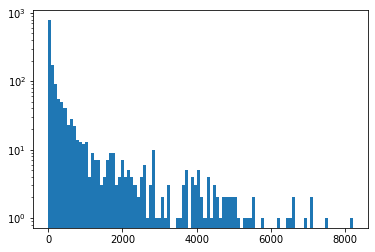

In [18]:
# Targets per TF
target_genes_per_protein_count = list()

for tf_protein_id, target_gene_ids in tf_protein_id_2_target_gene_id.items():
    target_genes_per_protein_count.append(len(target_gene_ids))

plt.yscale('log')
plt.hist(target_genes_per_protein_count, bins = 100);